This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:      303
Number of nonzeros in inequality constraint Jacobian.:      234
Number of nonzeros in Lagrangian Hessian.............:      420

Total number of variables............................:      123
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:       63
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.2000000e+01 0.00e+00 6.86e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

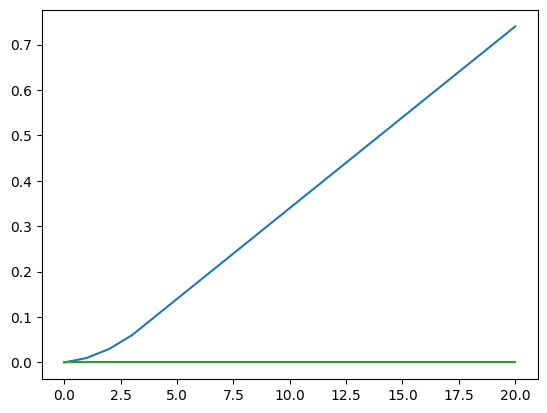

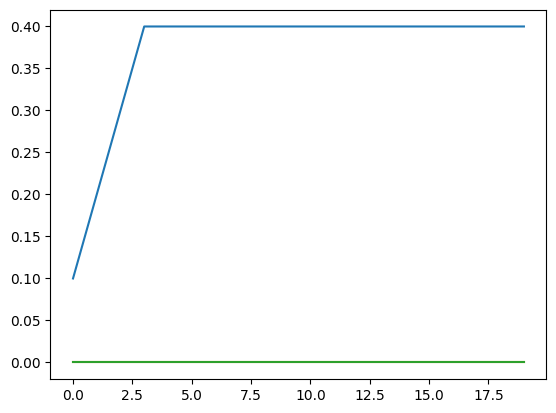

In [45]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

opti = ca.Opti()

T = 20
dt = 0.1

x = opti.variable(3,T+1)
x0 = opti.parameter(3)
u0 = opti.parameter(3)
x_des = opti.parameter(3)
u_des = opti.parameter(3)
u = opti.variable(3,T)
P = opti.parameter(6,6)
q = opti.parameter(6)

g=ca.DM(3,3)
g0=ca.DM(3,3)

# opti.set_value(x_des, np.array([10.0, 0, 0]))
opti.set_value(u_des, np.array([0.4, 0, 0]))
opti.set_value(x0, np.array([0, 0, 0]))
opti.set_value(u0, np.array([0, 0, 0]))

cost = 0

# stage cost
for i in range(T):
  cost += 0.1*(ca.vertcat(x[:,i],u[:,i]).T @ P.T @ P @ ca.vertcat(x[:,i],u[:,i]) + q.T @ ca.vertcat(x[:,i],u[:,i]))
  cost += 10*(u_des - u[:,i]).T @ (u_des - u[:,i])

# terminal cost
# cost += (x_des - x[:,T-1]).T @ (x_des - x[:,T-1])

opti.minimize( cost )

for i in range(T):
  opti.subject_to( x[0,i+1] == x[0,i] + dt * ( ca.cos(x[2,i]) * u[0,i] - ca.sin(x[2,i]) * u[1,i] + u[2,i] ) ) 
  opti.subject_to( x[1,i+1] == x[1,i] + dt * ( ca.sin(x[2,i]) * u[0,i] + ca.cos(x[2,i]) * u[1,i] + u[2,i] ) )
  opti.subject_to( x[2,i+1] == x[2,i] + dt * ( u[2,i] ) ) 

for i in range(T-1):
  opti.subject_to( u[:,i+1] - u[:,i] <= np.array([0.1, 0.1, 0.1]) )   
  opti.subject_to( u[:,i+1] - u[:,i] >= -np.array([0.1, 0.1, 0.1]) )   
  
opti.subject_to( x[:,0] == x0 )    

opti.subject_to( u[:,0] - u0 <= np.array([0.1, 0.1, 0.1]) )    
opti.subject_to( u[:,0] - u0 >= -np.array([0.1, 0.1, 0.1]) )    

opti.solver('ipopt')

opti.set_value(P, np.zeros((6,6)))
opti.set_value(q, np.zeros(6))
sol = opti.solve()
print(sol.value(x))
print(sol.value(u))

plt.plot(sol.value(x)[0,:])
plt.plot(sol.value(x)[1,:])
plt.plot(sol.value(x)[2,:])
plt.show()
plt.plot(sol.value(u)[0,:])
plt.plot(sol.value(u)[1,:])
plt.plot(sol.value(u)[2,:])
plt.show()
